<a href="https://colab.research.google.com/github/DrBottomBarrel/Projects_repository/blob/main/Depression_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

df = pd.read_csv('/content/drive/MyDrive/datasets/depression_data.csv')
df_new = df.copy()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print(df_new.isnull().sum())

# There are no empty data-cells in the dataframe
# But just to be sure let's drop the empty rows if they exist

df_new.dropna(inplace=True, axis=0)

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64


Now I am kind of stuck on what to do next
But Let me look at the descriptive statistics to decide what to do next.

>Well the dataset is already clean and organised hurray, so let's bin


we'll bin the income.

In [3]:
print(df_new.columns)
print(df_new.describe())
print(df_new.info())

Index(['Name', 'Age', 'Marital Status', 'Education Level',
       'Number of Children', 'Smoking Status', 'Physical Activity Level',
       'Employment Status', 'Income', 'Alcohol Consumption', 'Dietary Habits',
       'Sleep Patterns', 'History of Mental Illness',
       'History of Substance Abuse', 'Family History of Depression',
       'Chronic Medical Conditions'],
      dtype='object')
                 Age  Number of Children         Income
count  413768.000000       413768.000000  413768.000000
mean       49.000713            1.298972   50661.707971
std        18.158759            1.237054   40624.100565
min        18.000000            0.000000       0.410000
25%        33.000000            0.000000   21001.030000
50%        49.000000            1.000000   37520.135000
75%        65.000000            2.000000   76616.300000
max        80.000000            4.000000  209995.220000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 

In [4]:
income_bins = np.linspace(min(df_new['Income']), max(df_new['Income']), 4)
bin_names = ['poor', 'middle_class', 'rich']
df_new['binned_income'] = pd.cut(df_new['Income'], bins=income_bins, labels=bin_names, include_lowest=True)

pd.set_option('display.max_columns', None)    # so that I can see all my columns in the python shell
# print(df_new.head())
df_new.rename(columns={'binned_income': 'status'}, inplace=True)
# print(df_new.head())

I would normally start creating visualizations about now, but I am leaning toward statistical
analysis and modeling since I don't understand the dataset very much (it's also faster) because I understand the numbers
better.
First, let's save this dataframe for the visualization aspect we will cover after we are done with the model

In [5]:
df_new.to_csv('/content/drive/MyDrive/datasets/visualization_data.csv', index=False)

# now we go to modelling
df_model = df_new.copy()

del df_new #to save space

# let's convert all our categorical data columns to numeric data columns
# df_model.info()
cat_columns = ['Marital Status', 'Education Level', 'Smoking Status',
               'Physical Activity Level', 'Employment Status', 'Alcohol Consumption',
               'Dietary Habits', 'Sleep Patterns', 'History of Mental Illness',
               'History of Substance Abuse', 'Family History of Depression',
               'Chronic Medical Conditions', 'status']

cat_num = pd.get_dummies(df_model, columns=cat_columns)
print(cat_num.head())

# now we delete the 'df_model' dataframe to save space
del df_model


               Name  Age  Number of Children     Income  \
0  Christine Barker   31                   2   26265.67   
1  Jacqueline Lewis   55                   1   42710.36   
2    Shannon Church   78                   1  125332.79   
3    Charles Jordan   58                   3    9992.78   
4      Michael Rich   18                   0    8595.08   

   Marital Status_Divorced  Marital Status_Married  Marital Status_Single  \
0                    False                    True                  False   
1                    False                    True                  False   
2                    False                   False                  False   
3                     True                   False                  False   
4                    False                   False                   True   

   Marital Status_Widowed  Education Level_Associate Degree  \
0                   False                             False   
1                   False                             Fa

This is the first time i am using tensorflow or doing deep learning
Not my fault tho, the dataset has no obvious dependent variable i can use
I will rely on chat gpt for this part

In [6]:
data = cat_num.drop('Name', axis=1).values
data = data.astype('float32')
data = (data - data.mean(axis=0)) / data.std(axis=0)
input_dim = data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(data, data, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(data)

print(encoded_data.shape)

Epoch 1/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.8116 - val_loss: 0.7073
Epoch 2/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7102 - val_loss: 0.6942
Epoch 3/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6958 - val_loss: 0.6939
Epoch 4/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6970 - val_loss: 0.6938
Epoch 5/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6966 - val_loss: 0.6939
Epoch 6/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6970 - val_loss: 0.6938
Epoch 7/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6958 - val_loss: 0.6937
Epoch 8/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.6974 - val_loss: 0.6939
Epoch 9/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6968 - val_loss: 0.6940
Epoch 10/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6988 - val_loss: 0.6947
Epoch 11/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6969 - val_loss: 0.6937
Epoch 12/50
1294/1294 ━━━━

Let's Evaluate our model

Epoch 1/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6529 - val_loss: 0.6489
Epoch 2/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6507 - val_loss: 0.6488
Epoch 3/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6519 - val_loss: 0.6492
Epoch 4/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6521 - val_loss: 0.6488
Epoch 5/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6508 - val_loss: 0.6488
Epoch 6/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6507 - val_loss: 0.6488
Epoch 7/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6515 - val_loss: 0.6488
Epoch 8/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6516 - val_loss: 0.6488
Epoch 9/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6517 - val_loss: 0.6488
Epoch 10/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6507 - val_loss: 0.6488
Epoch 11/50
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6510 - val_loss: 0.6487
Epoch 12/50
1294/1294 ━━━

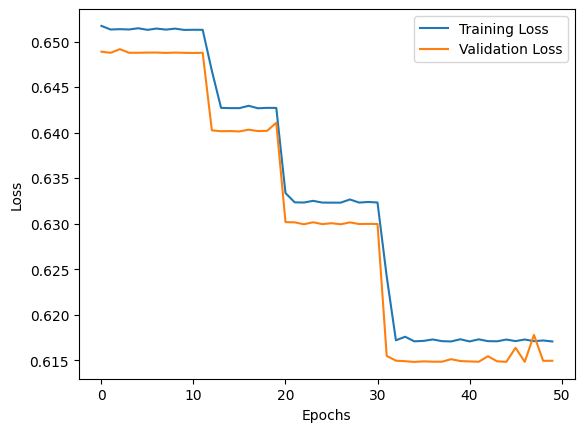

In [7]:
import matplotlib.pyplot as plt

history = autoencoder.fit(data, data, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Umm, it's the vertical scale that is problematic, my model isn't overfitted, hehe. YOU know what, let's showve this under the rug and move on, it's not like we'll be using this model for any deployment. I mean it's based on a dataset about depression. Let's move on.

Let's calculate the reconstruction error for confirmation, I am curious about how badly we messed up.

In [8]:
reconstructed_data = autoencoder.predict(data)
reconstruction_error = np.mean(np.square(data - reconstructed_data), axis=1)
print("Mean Reconstruction Error: ", np.mean(reconstruction_error))
print("Max Reconstruction Error: ", np.max(reconstruction_error))
print("Min Reconstruction Error: ", np.min(reconstruction_error))

12931/12931 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
Mean Reconstruction Error:  0.61673224
Max Reconstruction Error:  2.5146413
Min Reconstruction Error:  0.21911535


54%, ehh it's not too bad considering we are working with dataset not designed for machine learning. We are also working with underskilled data scientist, I think we should fire them, but I can keep thinking because we dont have the funds to hire better scientist.

> By the way, let's save our model



In [9]:
import os

model_path = '/content/drive/MyDrive/models/depression_model.h5'

if os.path.exists(model_path):
    print("Model already exists. Skipping saving.")
else:
    autoencoder = autoencoder.save(model_path)
    autoencoder
    print("Model saved successfully.")

Model already exists. Skipping saving.


Aaaand done. We'll now move on to the visualization aspect which is going to be more official and less quirky because we'll be dealing with stake holders.

Let's import the required modules.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

Let's Load our visualization dataset.

In [11]:
viz_path = '/content/drive/MyDrive/datasets/visualization_data.csv'
df_viz = pd.read_csv(viz_path)
df_viz.head(10)

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,status
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes,poor
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes,poor
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No,middle_class
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No,poor
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes,poor
5,Kathy Hill,20,Single,High School,0,Former,Active,Employed,44448.91,Low,Unhealthy,Fair,No,Yes,No,No,poor
6,Crystal Delgado,60,Widowed,Associate Degree,1,Non-smoker,Sedentary,Unemployed,22565.47,Moderate,Moderate,Poor,No,Yes,No,No,poor
7,Charles Kaiser,31,Single,High School,0,Non-smoker,Active,Employed,39608.18,Moderate,Unhealthy,Good,No,No,No,No,poor
8,Kathryn Taylor,50,Divorced,Bachelor's Degree,0,Non-smoker,Active,Employed,93360.07,Moderate,Healthy,Good,No,Yes,No,Yes,middle_class
9,Alexander Hernandez,77,Married,Bachelor's Degree,2,Non-smoker,Sedentary,Employed,77597.84,Low,Unhealthy,Poor,Yes,No,No,No,middle_class


Let's focus on 'Education Level', 'Employment Status', 'History of Substance Abuse', 'Physical Activity Level', 'Income' & 'status', 'Dietary Habits', and 'Sleep Patterns'  because i feel it's more generalised that way and can be applied to more people in the larger population

In [12]:
focus_cols = ['Name','Age','Education Level', 'Employment Status', 'History of Substance Abuse', 'Physical Activity Level', 'Income', 'status', 'Dietary Habits', 'Sleep Patterns']
df_use = df_viz[focus_cols]
del df_viz
df_use.head()

,Name,Age,Education Level,Employment Status,History of Substance Abuse,Physical Activity Level,Income,status,Dietary Habits,Sleep Patterns
0,Christine Barker,31,Bachelor's Degree,Unemployed,No,Active,26265.67,poor,Moderate,Fair
1,Jacqueline Lewis,55,High School,Employed,No,Sedentary,42710.36,poor,Unhealthy,Fair
2,Shannon Church,78,Master's Degree,Employed,No,Sedentary,125332.79,middle_class,Unhealthy,Good
3,Charles Jordan,58,Master's Degree,Unemployed,No,Moderate,9992.78,poor,Moderate,Poor
4,Michael Rich,18,High School,Unemployed,No,Sedentary,8595.08,poor,Moderate,Fair


Let's bin and drop the Age column

In [13]:
age_bins = np.linspace(min(df_use['Age']), max(df_use['Age']), 4)
labels = ['young', 'middle_aged', 'old']
df_use['binned_age'] = pd.cut(df_use['Age'], bins=age_bins, labels=labels, include_lowest=True)
df_use.drop('Age', axis=1, inplace=True)

In [14]:
df_use.rename(columns={'binned_age': 'Age_bracket'}, inplace=True)
df_use.rename(columns={'status': 'Economic_status'}, inplace=True)
df_use.head()

,Name,Education Level,Employment Status,History of Substance Abuse,Physical Activity Level,Income,Economic_status,Dietary Habits,Sleep Patterns,Age_bracket
0,Christine Barker,Bachelor's Degree,Unemployed,No,Active,26265.67,poor,Moderate,Fair,young
1,Jacqueline Lewis,High School,Employed,No,Sedentary,42710.36,poor,Unhealthy,Fair,middle_aged
2,Shannon Church,Master's Degree,Employed,No,Sedentary,125332.79,middle_class,Unhealthy,Good,old
3,Charles Jordan,Master's Degree,Unemployed,No,Moderate,9992.78,poor,Moderate,Poor,middle_aged
4,Michael Rich,High School,Unemployed,No,Sedentary,8595.08,poor,Moderate,Fair,young


We have a perferct dataset for visualiztions. We'll come back to this in like an hour, let my brain cool down a bit and come up with ideas on what to find out about...After much delibrattion, I have decided to use sql in transforming the dataset for each visualiztions to showcase my skills. Let's start by downloading and importing Pandasql.

In [15]:
!pip install pandasql
import pandasql as psql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=40a8ee798d8022fae7f6d5b2b1cde3c86737a416675b2cf52b47cf3d420b1aa1
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


Hmm let's find out just how many people in each education categories are depressed.

In [16]:
query1 = """
SELECT "Education Level", COUNT("Education Level") AS "Number of People"
FROM df_use
GROUP BY "Education Level"
"""
result1 = psql.sqldf(query1, globals())
print(result1)

     Education Level  Number of People
0   Associate Degree             79999
1  Bachelor's Degree            124329
2        High School            118927
3    Master's Degree             73768
4                PhD             16745


Let's Plot


Text(0.5, 0, 'Education Level')

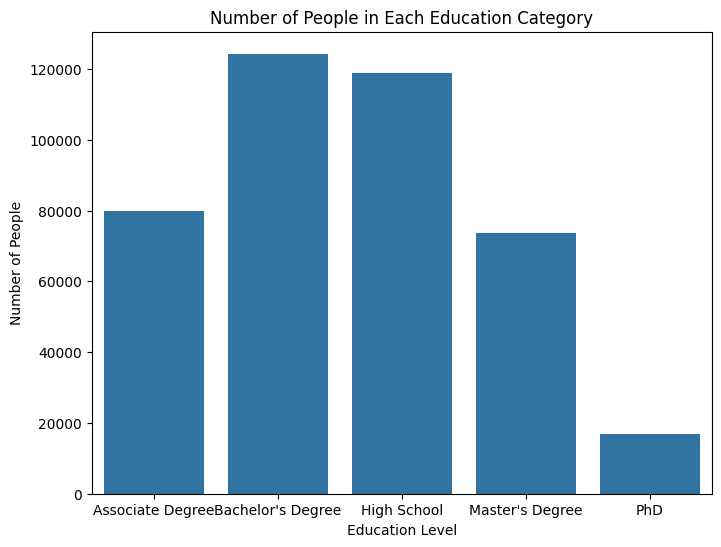

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Education Level', y='Number of People', data=result1)
plt.title('Number of People in Each Education Category')
plt.xlabel('Education Level')

So the most depressed people either have a High School or Bachelor's degree. My hypothesis on the reasin for this observation will be that these people are just stumbling into the economic world and job market for the first time (Just like me). But I don't have the resources to confirm this hypothesis and thus won't be investigating this further for now.

Let's look at how many of this people are into substance abuse

In [18]:
query2 = """
SELECT "Education Level", COUNT(*) AS "Number of People", "History of Substance Abuse"
FROM df_use
GROUP BY "Education Level", "History of Substance Abuse"
"""
result2 = psql.sqldf(query2, globals())
print(result2)

     Education Level  Number of People History of Substance Abuse
0   Associate Degree             55148                         No
1   Associate Degree             24851                        Yes
2  Bachelor's Degree             85837                         No
3  Bachelor's Degree             38492                        Yes
4        High School             81447                         No
5        High School             37480                        Yes
6    Master's Degree             50859                         No
7    Master's Degree             22909                        Yes
8                PhD             11589                         No
9                PhD              5156                        Yes


Let's visualize this


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

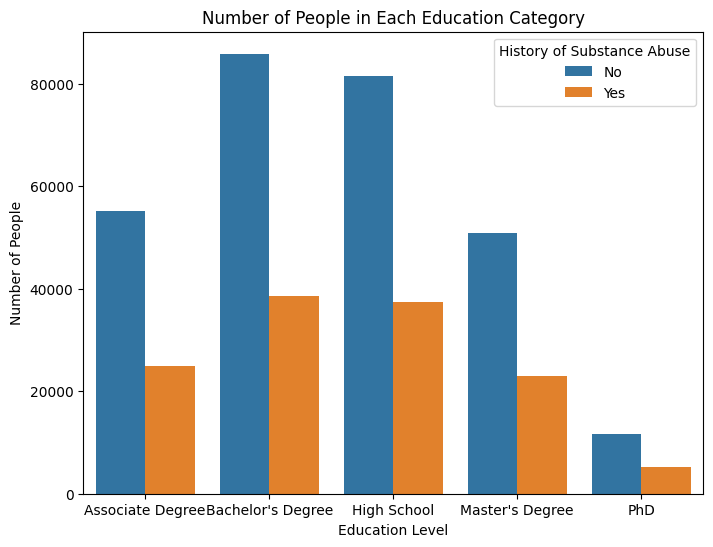

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Education Level', y='Number of People', hue='History of Substance Abuse', data=result2)
plt.title('Number of People in Each Education Category')
plt

Unexpectedly, the depressed population isn't dominated by substance abusers. This could mean that substance abuse is more a consequence than a cause of depression in the population.

Let's focus on the dietary habits of the population


In [20]:
query3 = """
SELECT "Dietary Habits", COUNT(*) AS "Number of People"
FROM df_use
GROUP BY "Dietary Habits"
"""
result3 = psql.sqldf(query3, globals())
print(result3)

  Dietary Habits  Number of People
0        Healthy             72505
1       Moderate            170446
2      Unhealthy            170817


Let's Visualize

Text(0.5, 0, 'Dietary Habit')

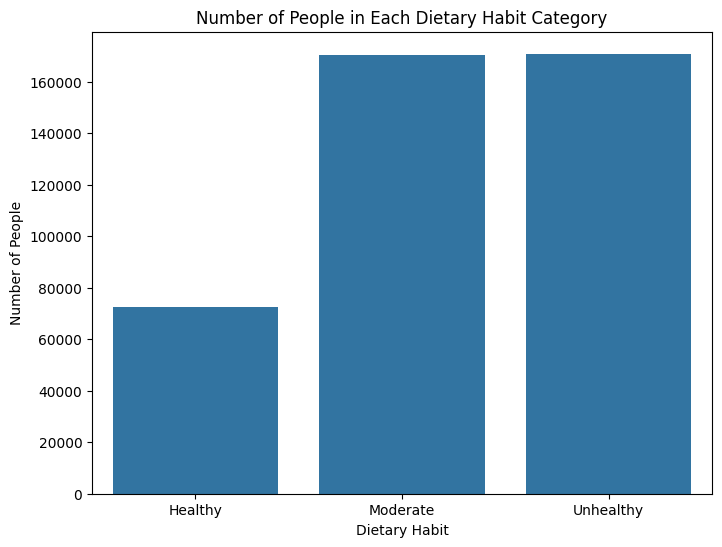

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Dietary Habits', y='Number of People', data=result3)
plt.title('Number of People in Each Dietary Habit Category')
plt.xlabel('Dietary Habit')

Clearly, people who don't eat a proper balanced diet tend to be more depressed. Please follow your doctor's recommendation and eat a healthy balanced diet.

We've been avoiding something called "finances", which could help support my hypothesis of the economics and job market having an effect on depressed feelings of the population.



In [22]:
query4 = """
SELECT "Economic_status", AVG(Income) AS Income, COUNT(*) AS "Number of People"
FROM df_use
GROUP BY "Economic_status"
"""
result4 = psql.sqldf(query4, globals())
print(result4)

  Economic_status         Income  Number of People
0    middle_class   97853.583663             96515
1            poor   29440.151269            300522
2            rich  159610.412821             16731


Let's put this on a graph sheet

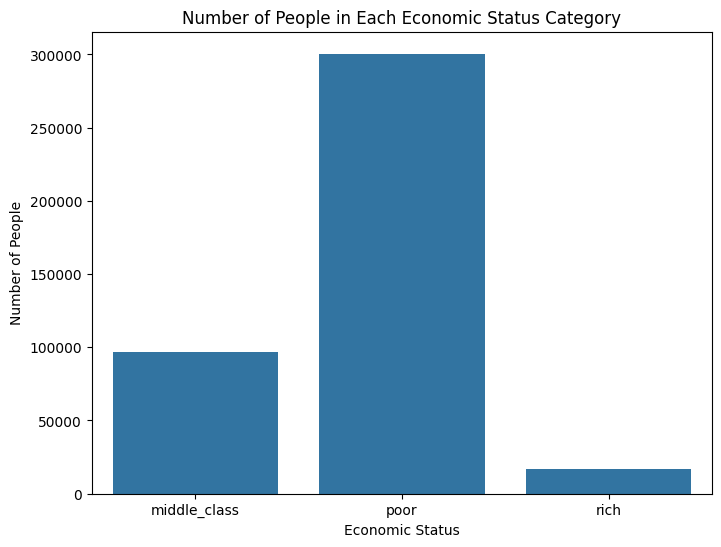

In [23]:
plt.figure(figsize=(8, 6))
# sns.lineplot(x='Number of People', y='Income', hue = 'Economic_status',data=result4)
sns.barplot(x='Economic_status', y='Number of People', data=result4)
plt.title('Number of People in Each Economic Status Category')
plt.xlabel('Economic Status')
plt.ylabel('Number of People')
plt.show()
# result4.dtypes

I am not completely sure but I can confidently say that alot of people are depressed because they are overwhelmed by their personal finances. Which is affected by the economic situation and job market generally.

###THINGS TO IMPROVE ON BEFORE THE NEXT PROJECT###
* Planning & Goal setting.
  + what is the objective of the project
  + what are the requirements needed to meet that objective
* Understaning the dataset better.
  + what each column is about or means
  + what kind of dataset your working with
  + relationship the columns in the datasets have with each other
  + the kind of values stored in each attributes/columns
* Knowing the libraries I will need to use before hand.
  + get a list of the libraries needed for working with the dataset in python
  + ensure these libraries are installed and ready to go
* keep a schedule of the process for the duration of the project